# COVID-19 Forecast Using AutoML package FLAML for Univariate and Possibly Multivariate Time Series Forecasting
## DS 440 

In [1]:
# Import packages
import numpy as np
import pystan
import pandas as pd
from flaml import AutoML
from sklearn.metrics import mean_squared_error
import datetime
from pandas import to_datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Using FLAML to Predict United States COVID-19 Cases

In [2]:
# read in dataset
df = pd.read_csv('covid.csv')

In [3]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2/24/2020,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2/25/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2/26/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2/27/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2/28/2020,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
# Quantify rows and columns
df.shape

(155261, 67)

In [5]:
# List of columns
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# Create different simple models for predicting number of deaths for one region (I'm choosing USA)

In [6]:
# Subset data for only US data
df_us = df.loc[df['location'] == 'United States']

In [7]:
df_us.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
146768,USA,North America,United States,1/22/2020,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146769,USA,North America,United States,1/23/2020,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146770,USA,North America,United States,1/24/2020,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146771,USA,North America,United States,1/25/2020,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
146772,USA,North America,United States,1/26/2020,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8925.0,-3.59,-2.63,-26.808639


In [256]:
# Subset for only the dates and total_cases columns (time series data only works with 
# one variable from what I can find)

df_us_cases = df_us[['date', 'total_cases']]
df_us_cases.head()

,date,total_cases
146768,1/22/2020,1.0
146769,1/23/2020,1.0
146770,1/24/2020,2.0
146771,1/25/2020,2.0
146772,1/26/2020,5.0


In [257]:
# Check for null values
print(df_us_cases['total_cases'].isnull().sum())
print(df_us_cases['total_cases'].isna().sum())

0
0


In [258]:
df_us_cases.index = pd.to_datetime(df_us_cases['date'], format = '%m/%d/%Y')
df_us_cases.head()

,date,total_cases
date,,
2020-01-22,1/22/2020,1.0
2020-01-23,1/23/2020,1.0
2020-01-24,1/24/2020,2.0
2020-01-25,1/25/2020,2.0
2020-01-26,1/26/2020,5.0


In [259]:
train = df_us_cases[df_us_cases.index < pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
test = df_us_cases[df_us_cases.index >= pd.to_datetime('2021-12-01', format='%Y-%m-%d')]

In [260]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [261]:
X_train = train['date']
y_train = train['total_cases']

X_test = test['date']
y_test = test['total_cases']

X_train = X_train.to_frame().reset_index()
del X_train['index']
X_test = X_test.to_frame().reset_index()
del X_test['index']

In [262]:
X_train['date'] = pd.to_datetime(X_train['date'], format='%m/%d/%Y')
X_test['date'] = pd.to_datetime(X_test['date'], format='%m/%d/%Y')

In [264]:
automl = AutoML()

In [269]:
automl.fit(X_train,  # a single column of timestamp
           y_train,  # value for each timestamp
           period=12,  # time horizon to forecast, e.g., 12 months
           task='ts_forecast', time_budget=30,  # time budget in seconds
           log_file_name="ts_forecast.log",
           eval_method="cv",
          )
print(automl.predict(X_train))

[flaml.automl: 02-17 15:15:29] {2055} INFO - task = ts_forecast
INFO:flaml.automl:task = ts_forecast
[flaml.automl: 02-17 15:15:29] {2057} INFO - Data split method: time
INFO:flaml.automl:Data split method: time
[flaml.automl: 02-17 15:15:29] {2061} INFO - Evaluation method: cv
INFO:flaml.automl:Evaluation method: cv
[flaml.automl: 02-17 15:15:29] {2142} INFO - Minimizing error metric: mape
INFO:flaml.automl:Minimizing error metric: mape
[flaml.automl: 02-17 15:15:29] {2200} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'prophet', 'arima', 'sarimax']
INFO:flaml.automl:List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'prophet', 'arima', 'sarimax']
[flaml.automl: 02-17 15:15:29] {2453} INFO - iteration 0, current learner lgbm
INFO:flaml.automl:iteration 0, current learner lgbm
[flaml.automl: 02-17 15:15:30] {2568} INFO - Estimated sufficient time budget=1735s. Estimated necessary time budget

[flaml.automl: 02-17 15:15:48] {2453} INFO - iteration 19, current learner arima
INFO:flaml.automl:iteration 19, current learner arima
[flaml.automl: 02-17 15:15:49] {2615} INFO -  at 20.0s,	estimator arima's best error=0.0024,	best estimator arima's best error=0.0024
INFO:flaml.automl: at 20.0s,	estimator arima's best error=0.0024,	best estimator arima's best error=0.0024
[flaml.automl: 02-17 15:15:49] {2453} INFO - iteration 20, current learner xgboost
INFO:flaml.automl:iteration 20, current learner xgboost
[flaml.automl: 02-17 15:15:50] {2615} INFO -  at 20.2s,	estimator xgboost's best error=0.0246,	best estimator arima's best error=0.0024
INFO:flaml.automl: at 20.2s,	estimator xgboost's best error=0.0246,	best estimator arima's best error=0.0024
[flaml.automl: 02-17 15:15:50] {2453} INFO - iteration 21, current learner sarimax
INFO:flaml.automl:iteration 21, current learner sarimax
[flaml.automl: 02-17 15:15:51] {2615} INFO -  at 21.3s,	estimator sarimax's best error=0.0024,	best e

INFO:flaml.automl: at 39.9s,	estimator sarimax's best error=0.0024,	best estimator sarimax's best error=0.0024
[flaml.automl: 02-17 15:16:09] {2453} INFO - iteration 41, current learner xgb_limitdepth
INFO:flaml.automl:iteration 41, current learner xgb_limitdepth
[flaml.automl: 02-17 15:16:09] {2615} INFO -  at 40.2s,	estimator xgb_limitdepth's best error=0.0112,	best estimator sarimax's best error=0.0024
INFO:flaml.automl: at 40.2s,	estimator xgb_limitdepth's best error=0.0112,	best estimator sarimax's best error=0.0024
[flaml.automl: 02-17 15:16:09] {2453} INFO - iteration 42, current learner arima
INFO:flaml.automl:iteration 42, current learner arima
[flaml.automl: 02-17 15:16:12] {2615} INFO -  at 42.3s,	estimator arima's best error=0.0024,	best estimator sarimax's best error=0.0024
INFO:flaml.automl: at 42.3s,	estimator arima's best error=0.0024,	best estimator sarimax's best error=0.0024
[flaml.automl: 02-17 15:16:12] {2453} INFO - iteration 43, current learner rf
INFO:flaml.auto

2020-01-22    0.000000e+00
2020-01-23    1.568263e+00
2020-01-24    1.583871e+00
2020-01-25    2.659018e+00
2020-01-26    2.618753e+00
                  ...     
2021-11-26    4.820637e+07
2021-11-27    4.825757e+07
2021-11-28    4.827281e+07
2021-11-29    4.831413e+07
2021-11-30    4.854413e+07
Freq: D, Name: predicted_mean, Length: 679, dtype: float64


48


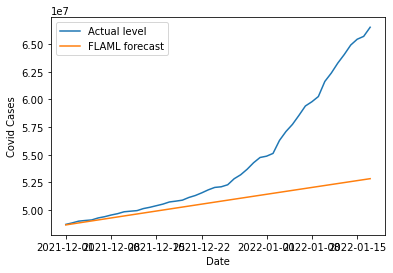

In [270]:
# predict test set
flaml_y_pred = automl.predict(X_test)
plt.plot(X_test, y_test, label='Actual level')
plt.plot(X_test, flaml_y_pred, label='FLAML forecast')
plt.xlabel('Date')
plt.ylabel('Covid Cases')
plt.legend()

# Using FLAML to Predict United States COVID-19 Deaths

In [8]:
# Subset for only the dates and total_cases columns (time series data only works with 
# one variable from what I can find)

df_us_deaths = df_us[['date', 'total_deaths']]
df_us_deaths.head()

,date,total_deaths
146768,1/22/2020,NaN
146769,1/23/2020,NaN
146770,1/24/2020,NaN
146771,1/25/2020,NaN
146772,1/26/2020,NaN


In [11]:
df_us_deaths = df_us_deaths.dropna()
print(df_us_deaths['total_deaths'].isnull().sum())
print(df_us_deaths['total_deaths'].isna().sum())

0
0


In [12]:
df_us_deaths.index = pd.to_datetime(df_us_deaths['date'], format = '%m/%d/%Y')
df_us_deaths.head()

,date,total_deaths
date,,
2020-02-29,2/29/2020,1.0
2020-03-01,3/1/2020,1.0
2020-03-02,3/2/2020,6.0
2020-03-03,3/3/2020,7.0
2020-03-04,3/4/2020,11.0


In [13]:
train = df_us_deaths[df_us_deaths.index < pd.to_datetime('2021-12-01', format='%Y-%m-%d')]
test = df_us_deaths[df_us_deaths.index >= pd.to_datetime('2021-12-01', format='%Y-%m-%d')]

In [14]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [15]:
X_train = train['date']
y_train = train['total_deaths']

X_test = test['date']
y_test = test['total_deaths']

X_train = X_train.to_frame().reset_index()
del X_train['index']
X_test = X_test.to_frame().reset_index()
del X_test['index']

In [16]:
X_train['date'] = pd.to_datetime(X_train['date'], format='%m/%d/%Y')
X_test['date'] = pd.to_datetime(X_test['date'], format='%m/%d/%Y')

In [17]:
automl = AutoML()

In [18]:
automl.fit(X_train,  # a single column of timestamp
           y_train,  # value for each timestamp
           period=12,  # time horizon to forecast, e.g., 12 months
           task='ts_forecast', time_budget=30,  # time budget in seconds
           log_file_name="ts_forecast.log",
           eval_method="cv",
          )
print(automl.predict(X_train))

[flaml.automl: 02-24 15:37:22] {2055} INFO - task = ts_forecast
INFO:flaml.automl:task = ts_forecast
[flaml.automl: 02-24 15:37:22] {2057} INFO - Data split method: time
INFO:flaml.automl:Data split method: time
[flaml.automl: 02-24 15:37:22] {2061} INFO - Evaluation method: cv
INFO:flaml.automl:Evaluation method: cv
[flaml.automl: 02-24 15:37:22] {2142} INFO - Minimizing error metric: mape
INFO:flaml.automl:Minimizing error metric: mape
[flaml.automl: 02-24 15:37:23] {2200} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'prophet', 'arima', 'sarimax']
INFO:flaml.automl:List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'prophet', 'arima', 'sarimax']
[flaml.automl: 02-24 15:37:23] {2453} INFO - iteration 0, current learner lgbm
INFO:flaml.automl:iteration 0, current learner lgbm
[flaml.automl: 02-24 15:37:28] {2568} INFO - Estimated sufficient time budget=58501s. Estimated necessary time budge

INFO:flaml.automl: at 13.9s,	estimator lgbm's best error=0.0140,	best estimator lgbm's best error=0.0140
[flaml.automl: 02-24 15:37:36] {2453} INFO - iteration 20, current learner lgbm
INFO:flaml.automl:iteration 20, current learner lgbm
[flaml.automl: 02-24 15:37:37] {2615} INFO -  at 14.4s,	estimator lgbm's best error=0.0140,	best estimator lgbm's best error=0.0140
INFO:flaml.automl: at 14.4s,	estimator lgbm's best error=0.0140,	best estimator lgbm's best error=0.0140
[flaml.automl: 02-24 15:37:37] {2453} INFO - iteration 21, current learner lgbm
INFO:flaml.automl:iteration 21, current learner lgbm
[flaml.automl: 02-24 15:37:37] {2615} INFO -  at 14.9s,	estimator lgbm's best error=0.0139,	best estimator lgbm's best error=0.0139
INFO:flaml.automl: at 14.9s,	estimator lgbm's best error=0.0139,	best estimator lgbm's best error=0.0139
[flaml.automl: 02-24 15:37:37] {2453} INFO - iteration 22, current learner lgbm
INFO:flaml.automl:iteration 22, current learner lgbm
[flaml.automl: 02-24 1

[flaml.automl: 02-24 15:37:46] {2453} INFO - iteration 42, current learner lgbm
INFO:flaml.automl:iteration 42, current learner lgbm
[flaml.automl: 02-24 15:37:47] {2615} INFO -  at 24.6s,	estimator lgbm's best error=0.0128,	best estimator lgbm's best error=0.0128
INFO:flaml.automl: at 24.6s,	estimator lgbm's best error=0.0128,	best estimator lgbm's best error=0.0128
[flaml.automl: 02-24 15:37:47] {2453} INFO - iteration 43, current learner lgbm
INFO:flaml.automl:iteration 43, current learner lgbm
[flaml.automl: 02-24 15:37:47] {2615} INFO -  at 25.0s,	estimator lgbm's best error=0.0128,	best estimator lgbm's best error=0.0128
INFO:flaml.automl: at 25.0s,	estimator lgbm's best error=0.0128,	best estimator lgbm's best error=0.0128
[flaml.automl: 02-24 15:37:47] {2453} INFO - iteration 44, current learner rf
INFO:flaml.automl:iteration 44, current learner rf
[flaml.automl: 02-24 15:37:48] {2615} INFO -  at 25.4s,	estimator rf's best error=0.1437,	best estimator lgbm's best error=0.0128
I

[5.14586753e+02 5.14586753e+02 5.14586753e+02 5.14586753e+02
 5.14586753e+02 5.14586753e+02 5.14586753e+02 5.14586753e+02
 5.14586753e+02 5.14586753e+02 5.14586753e+02 5.14586753e+02
 5.14586753e+02 5.14586753e+02 5.14586753e+02 4.16751018e+03
 4.16751018e+03 4.16751018e+03 4.16751018e+03 4.16751018e+03
 4.16751018e+03 1.19391593e+04 1.19391593e+04 1.19391593e+04
 1.19391593e+04 1.19391593e+04 1.19391593e+04 2.20355181e+04
 2.20355181e+04 2.20355181e+04 2.79462501e+04 2.79462501e+04
 2.79462501e+04 3.44091893e+04 3.44091893e+04 3.44091893e+04
 3.95102144e+04 3.95102144e+04 3.95102144e+04 4.74960480e+04
 4.74960480e+04 4.74960480e+04 5.62726503e+04 5.62726503e+04
 5.62726503e+04 5.94559726e+04 5.94559726e+04 5.94559726e+04
 6.62124415e+04 6.62124415e+04 6.62124415e+04 7.09099974e+04
 7.09099974e+04 7.09099974e+04 7.69532262e+04 7.69532262e+04
 7.69532262e+04 8.17763887e+04 8.17763887e+04 8.17763887e+04
 8.82698355e+04 8.82698355e+04 8.82698355e+04 8.82698355e+04
 8.82698355e+04 8.826983

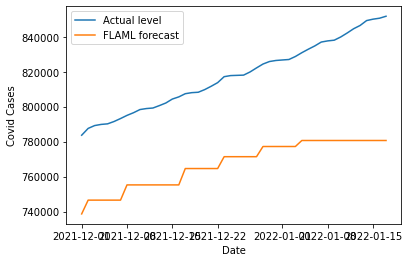

In [19]:
# predict test set
flaml_y_pred = automl.predict(X_test)
plt.plot(X_test, y_test, label='Actual level')
plt.plot(X_test, flaml_y_pred, label='FLAML forecast')
plt.xlabel('Date')
plt.ylabel('Covid Cases')
plt.legend()